Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on 18 December 2019

In [261]:
import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
import os
import glob
import numpy as np
import pandas as pd
import os
import glob



## Load the results

In [262]:
#yearly_bau_results_df = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/VICSimDataYearSummary_1512021-BAU-1918-2051.csv', index_col='Time (Year)')
# simulation results BAU
yearly_bau_results_df = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/VICSimDataYearSummary_140221-BAU-1902-2051.csv', index_col='Time (Year)')

# Energy vulnerability results
ev_results_df = pd.read_excel(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/notebookGr4sp/outputs/data/EV_oneScenario.xlsx', index_col=[0,1,2])

# Organisational networks - indicators

sna_gephi_indicators = pd.read_csv (r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/organisational_networks_indicators.csv', index_col='Time (Year)')


In [263]:
#outcomes Options: wholesalePriceYear, GHGYear, tariffsYear, primarySpotProductionYear,
# secondarySpotProductionYear, offSpotProductionYear, rooftopPvProductionYear
# # numActorsYear
# outcomes_to_show = ['consumptionYear', 'tariffsYear', 'wholesalePriceYear', 'GHGYear', 
#                     'numConsumersYear', 'primarySpotProductionYear', 'secondarySpotProductionYear', 
#                     'offSpotProductionYear', 'renewableContributionYear', 'rooftopPVProductionYear', 
#                     'coalProductionYear', 'waterProductionYear', 'windProductionYear', 'gasProductionYear', 
#                     'solarProductionYear', 'BatteryProductionYear', 'numActorsYear', 'primaryUnmetDemandMwh', 
#                     'primaryUnmetDemandHours', 'primaryUnmetDemandDays', 'primaryMaxUnmetDemandMwhPerHour', 
#                     'secondaryUnmetDemandMwh', 'secondaryUnmetDemandHours', 'secondaryUnmetDemandDays', 
#                     'secondaryMaxUnmetDemandMwhPerHour']

yearly_bau_results_df['Energy Vulnerability'] = ev_results_df.mean()
yearly_bau_results_df['Energy Vulnerability'] = yearly_bau_results_df['Energy Vulnerability'].fillna(0)


""" Converts household data in tCO2e into total residential data in MtCO2e"""
data_GHG_residential = (yearly_bau_results_df['GHG Emissions (tCO2-e) per household'] * yearly_bau_results_df['Number of Domestic Consumers (households)']) / 1000000.0

""" Applies scaling factor used in simulation, so that data represents total emissions, not only residential (30%)"""
data_GHG_total = data_GHG_residential / 0.3

"""Overwrite GHG with the data of interest"""
yearly_bau_results_df['GHG Emissions (MtCO2-e) VIC'] = data_GHG_total

outcomes_to_show = [
                    'Avg Tariff (c/KWh) per household',
                    'Primary Wholesale ($/MWh)',
                    'GHG Emissions (MtCO2-e) VIC',
                    'Percentage Renewable Production',
                    'Primary Total Unmet Demand (Hours)',
                    'Energy Vulnerability'
                   ]

minIsBest = {
                'Avg Tariff (c/KWh) per household': True,
                'Primary Wholesale ($/MWh)': True,
                'GHG Emissions (MtCO2-e) VIC': True,
                'Percentage Renewable Production': False,
                'Primary Total Unmet Demand (Hours)': True,
                'Energy Vulnerability': True
}

reference_year_r1 = 1990
reference_year_r2 = 1990
reference_year_r3 = 1990
reference_year_future = 2005

snapshot_years_r1 = [1908]
snapshot_years_r2 = [1927,1947,1967,1985]
snapshot_years_r3 = [2002,2014,2019]
snapshot_years_future = [2020,2030,2040,2050] 
snapshot_years = [1908,1927,1947,1967,1985,2020,2030,2040,2050] 

#snapshot_years = yearly_bau_results_df.index


Fill in missing data

In [264]:
# Regime I. 
# Assumption wholesale price: wholesale price equals the production cost, which is a percentage of the tariff
r1_prod_cost_from_tariff = 0.5

# Assumption unmet demand (hours per year): first 30 years, minimum residential demand
# (1880-1910), almost all year; 1911-1919, 90% of the time; 

r1_unmet_demand_1880_1910 = 365*24
r1_unmet_demand_1911_1919 = (365*24)*0.95

#energy vulnerability. Most people did not have access to electricity, but other fuels were available for cooking and heating.
r1_ev_1880_1919 = 0.9

# Regimen II. 
# Assumption wholesale prices: SECV assumed to have a roi of 15%
r2_prod_cost_from_tariff = 0.85

# Assumption unmet demand (hours per year): 1920-1940; 1941-1961; 

r2_unmet_demand_1920_1940 = (365*24)*0.8
r2_unmet_demand_1941_1960 = (365*24)*0.3
r2_unmet_demand_1961_1980 = (365*24)*0.05
r2_unmet_demand_1981_1989 = (365*24)*0.05

# energy vulnerability 
r2_ev_1920_1940 = 0.8
r2_ev_1941_1960 = 0.4
r2_ev_1961_1980 = 0.3
r2_ev_1981_1989 = 0.2



for y in snapshot_years: 
    if y < 1910:  
        yearly_bau_results_df['Primary Total Unmet Demand (Hours)'][y] =  r1_unmet_demand_1880_1910

    if y < 1920:
        yearly_bau_results_df['Primary Wholesale ($/MWh)'][y] = yearly_bau_results_df['Avg Tariff (c/KWh) per household'][y] * r1_prod_cost_from_tariff
        yearly_bau_results_df['Primary Total Unmet Demand (Hours)'][y] = r1_unmet_demand_1911_1919
        yearly_bau_results_df['Energy Vulnerability'][y] =  r1_ev_1880_1919
    
    if 1940 > y >= 1920:
        yearly_bau_results_df['Primary Total Unmet Demand (Hours)'][y] = r2_unmet_demand_1920_1940
        yearly_bau_results_df['Energy Vulnerability'][y] =  r2_ev_1920_1940

    if 1960 > y >= 1941:
        yearly_bau_results_df['Primary Total Unmet Demand (Hours)'][y] = r2_unmet_demand_1941_1960
        yearly_bau_results_df['Energy Vulnerability'][y] =  r2_ev_1941_1960
    
    if 1980 > y >= 1961:
        yearly_bau_results_df['Primary Total Unmet Demand (Hours)'][y] = r2_unmet_demand_1961_1980
        yearly_bau_results_df['Energy Vulnerability'][y] =  r2_ev_1961_1980
        
    if 1989 > y >= 1981:
        yearly_bau_results_df['Primary Total Unmet Demand (Hours)'][y] = r2_unmet_demand_1981_1989
        yearly_bau_results_df['Energy Vulnerability'][y] =  r2_ev_1981_1989

    if 1998 > y >= 1920:
        yearly_bau_results_df['Primary Wholesale ($/MWh)'][y] = yearly_bau_results_df['Avg Tariff (c/KWh) per household'][y] * r2_prod_cost_from_tariff
    if y > 2040:
        yearly_bau_results_df['Energy Vulnerability'][y] = yearly_bau_results_df['Energy Vulnerability'][2040] 

        
        
        
        

In [265]:
yearly_bau_results_df[outcomes_to_show].filter(items=snapshot_years, axis=0)

,Avg Tariff (c/KWh) per household,Primary Wholesale ($/MWh),GHG Emissions (MtCO2-e) VIC,Percentage Renewable Production,Primary Total Unmet Demand (Hours),Energy Vulnerability
Time (Year),,,,,,
1908,305.855316,152.927658,0.000000,0.000000,8322.0,0.900000
1927,187.898956,159.714113,1.232608,0.000000,7008.0,0.800000
1947,240.743805,204.632234,3.403005,0.104073,2628.0,0.400000
1967,90.762245,77.147908,14.416623,0.052356,438.0,0.300000
1985,31.208897,26.527562,34.264837,0.019205,438.0,0.200000
2020,32.562569,40.962314,44.631640,0.240063,318.0,0.363308
2030,11.051490,103.195795,37.744131,0.326989,100.0,0.347749
2040,27.531506,138.430541,30.422739,0.491408,2546.0,0.361406
2050,25.198570,155.237729,3.953361,0.898984,8437.0,0.361406


## Spiders

### Regimen 1

Load Data and Normalize each dimension

In [266]:
data = yearly_bau_results_df[outcomes_to_show].filter(items=snapshot_years_r1, axis=0)

categories = data.columns

for c in categories:
    col = data.loc[:,c]
    if minIsBest[c]: col *= -1
    normalized_col = (col - col.min())/(col.max() - col.min())
    data.loc[:,c] = normalized_col

Plot take 1

In [267]:
%matplotlib inline
import plotly.graph_objects as go

ooi = 'bau'


fig = go.Figure()

for year, row in data.iterrows():
    fig.add_trace(go.Scatterpolar(
      r=row[0:],
      theta=categories,
      fill='toself',
      opacity=0.4,
      name="{}".format(year)
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    title="nBL BAU",
    font=dict(
        family="Courier New, monospace",
        size=15,
        color="#7f7f7f"
    ),
    autosize=True
)

## requires orca to be installed: conda install -c plotly plotly-orca
#fig.write_image('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', '_nbl_spider_%s'%(ooi)))
fig.show()
   

Format Data for a cooler visualization

In [268]:
dataDf = pd.DataFrame(columns={'Dimension','Year','Value'})
for year, row in data.iterrows():
    for index, value in row.items():
        dataDf = dataDf.append({'Dimension': index,'Year':year,'Value':value} , ignore_index=True)



Use Alternative visualization that helps distinguishing each year

In [269]:
import plotly.express as px
df = px.data.wind()
# fig = px.line_polar(df, r="frequency", theta="direction", color="strength", line_close=True,
#                     color_discrete_sequence=px.colors.sequential.Plasma,
#                     template="plotly_dark",)
fig = px.line_polar(dataDf, r="Value", theta="Dimension", color="Year", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma,
                    template="plotly_dark")
fig.show()



### Regime 2

In [270]:
data = yearly_bau_results_df[outcomes_to_show].filter(items=snapshot_years_r2, axis=0)

categories = data.columns

for c in categories:
    col = data.loc[:,c]
    if minIsBest[c]: col *= -1
    normalized_col = (col - col.min())/(col.max() - col.min())
    data.loc[:,c] = normalized_col

In [271]:
%matplotlib inline
import plotly.graph_objects as go

ooi = 'bau'


fig = go.Figure()

for year, row in data.iterrows():
    fig.add_trace(go.Scatterpolar(
      r=row[0:],
      theta=categories,
      fill='toself',
      opacity=0.4,
      name="{}".format(year)
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    title="nBL BAU",
    font=dict(
        family="Courier New, monospace",
        size=15,
        color="#7f7f7f"
    ),
    autosize=True
)

## requires orca to be installed: conda install -c plotly plotly-orca
#fig.write_image('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', '_nbl_spider_%s'%(ooi)))
fig.show()
   

In [272]:
dataDf = pd.DataFrame(columns={'Dimension','Year','Value'})
for year, row in data.iterrows():
    for index, value in row.items():
        dataDf = dataDf.append({'Dimension': index,'Year':year,'Value':value} , ignore_index=True)



In [273]:
import plotly.express as px
df = px.data.wind()
# fig = px.line_polar(df, r="frequency", theta="direction", color="strength", line_close=True,
#                     color_discrete_sequence=px.colors.sequential.Plasma,
#                     template="plotly_dark",)
fig = px.line_polar(dataDf, r="Value", theta="Dimension", color="Year", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma,
                    template="plotly_dark")
fig.show()



### Regime 3

In [274]:
data = yearly_bau_results_df[outcomes_to_show].filter(items=snapshot_years_r3, axis=0)

categories = data.columns

for c in categories:
    col = data.loc[:,c]
    if minIsBest[c]: col *= -1
    normalized_col = (col - col.min())/(col.max() - col.min())
    data.loc[:,c] = normalized_col

In [275]:
%matplotlib inline
import plotly.graph_objects as go

ooi = 'bau'


fig = go.Figure()

for year, row in data.iterrows():
    fig.add_trace(go.Scatterpolar(
      r=row[0:],
      theta=categories,
      fill='toself',
      opacity=0.4,
      name="{}".format(year)
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    title="nBL BAU",
    font=dict(
        family="Courier New, monospace",
        size=15,
        color="#7f7f7f"
    ),
    autosize=True
)

## requires orca to be installed: conda install -c plotly plotly-orca
#fig.write_image('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', '_nbl_spider_%s'%(ooi)))
fig.show()
   

In [276]:
dataDf = pd.DataFrame(columns={'Dimension','Year','Value'})
for year, row in data.iterrows():
    for index, value in row.items():
        dataDf = dataDf.append({'Dimension': index,'Year':year,'Value':value} , ignore_index=True)



In [277]:
import plotly.express as px
df = px.data.wind()
# fig = px.line_polar(df, r="frequency", theta="direction", color="strength", line_close=True,
#                     color_discrete_sequence=px.colors.sequential.Plasma,
#                     template="plotly_dark",)
fig = px.line_polar(dataDf, r="Value", theta="Dimension", color="Year", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma,
                    template="plotly_dark")
fig.show()



### Future

In [278]:
data = yearly_bau_results_df[outcomes_to_show].filter(items=snapshot_years_future, axis=0)

categories = data.columns

for c in categories:
    col = data.loc[:,c]
    if minIsBest[c]: col *= -1
    normalized_col = (col - col.min())/(col.max() - col.min())
    data.loc[:,c] = normalized_col

In [279]:
%matplotlib inline
import plotly.graph_objects as go

ooi = 'bau'


fig = go.Figure()

for year, row in data.iterrows():
    fig.add_trace(go.Scatterpolar(
      r=row[0:],
      theta=categories,
      fill='toself',
      opacity=0.4,
      name="{}".format(year)
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    title="nBL BAU",
    font=dict(
        family="Courier New, monospace",
        size=15,
        color="#7f7f7f"
    ),
    autosize=True
)

## requires orca to be installed: conda install -c plotly plotly-orca
#fig.write_image('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', '_nbl_spider_%s'%(ooi)))
fig.show()
   

In [280]:
dataDf = pd.DataFrame(columns={'Dimension','Year','Value'})
for year, row in data.iterrows():
    for index, value in row.items():
        dataDf = dataDf.append({'Dimension': index,'Year':year,'Value':value} , ignore_index=True)



In [281]:
import plotly.express as px
df = px.data.wind()
# fig = px.line_polar(df, r="frequency", theta="direction", color="strength", line_close=True,
#                     color_discrete_sequence=px.colors.sequential.Plasma,
#                     template="plotly_dark",)
fig = px.line_polar(dataDf, r="Value", theta="Dimension", color="Year", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma,
                    template="plotly_dark")
fig.show()



## Ranking of snapshot years

In [282]:
data = yearly_bau_results_df[outcomes_to_show].filter(items=snapshot_years, axis=0)

categories = data.columns

data_rank = data.rank(method="first")
for c in categories:
    if minIsBest[c] is True: 
        data_rank[c] = data[c].rank(method="min")
    else:
        data_rank[c] = data[c].rank(method="min", ascending=False)
maxRank = data_rank.max().max()+1

data_rank


,Avg Tariff (c/KWh) per household,Primary Wholesale ($/MWh),GHG Emissions (MtCO2-e) VIC,Percentage Renewable Production,Primary Total Unmet Demand (Hours),Energy Vulnerability
Time (Year),,,,,,
1908,9.0,6.0,1.0,8.0,8.0,9.0
1927,7.0,8.0,2.0,8.0,7.0,8.0
1947,8.0,9.0,3.0,5.0,6.0,7.0
1967,6.0,3.0,5.0,6.0,3.0,2.0
1985,4.0,1.0,7.0,7.0,3.0,1.0
2020,5.0,2.0,9.0,4.0,2.0,6.0
2030,1.0,4.0,8.0,3.0,1.0,3.0
2040,3.0,5.0,6.0,2.0,5.0,4.0
2050,2.0,7.0,4.0,1.0,9.0,4.0


In [283]:
%matplotlib inline
import plotly.graph_objects as go

ooi = 'bau'


fig = go.Figure()

for year, row in data_rank.iterrows():
    fig.add_trace(go.Scatterpolar(
      r=row[0:],
      theta=categories,
      fill='toself',
      opacity=0.4,
      name="{}".format(year)
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, maxRank]
        )),
    showlegend=True,
    title="nBL BAU",
    font=dict(
        family="Courier New, monospace",
        size=15,
        color="#7f7f7f"
    ),
    autosize=True
)

## requires orca to be installed: conda install -c plotly plotly-orca
#fig.write_image('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\figs', '_nbl_spider_%s'%(ooi)))
fig.show()

In [284]:
dataDf = pd.DataFrame(columns={'Dimension','Year','Value'})
for year, row in data_rank.iterrows():
    for index, value in row.items():
        dataDf = dataDf.append({'Dimension': index,'Year':year,'Value':value} , ignore_index=True)

import plotly.express as px
df = px.data.wind()
# fig = px.line_polar(df, r="frequency", theta="direction", color="strength", line_close=True,
#                     color_discrete_sequence=px.colors.sequential.Plasma,
#                     template="plotly_dark",)
fig = px.line_polar(dataDf, r="Value", theta="Dimension", color="Year", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma,
                    template="plotly_dark")
fig.show()

# Bump Char

In [285]:
from scipy import interpolate


sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.2)

In [286]:
from collections import defaultdict

def add_widths(x, y, width=0.1):
    """ Adds flat parts to widths """
    new_x = []
    new_y = []
    for i,j in zip(x,y):
        new_x += [i-width, i, i+width]
        new_y += [j, j, j]
    return new_x, new_y

def bumpsplot(dataframe, color_dict=defaultdict(lambda: "k"), 
                         linewidth_dict=defaultdict(lambda: 1),
                         labels=[]):
    r = dataframe
    maxRank=r.max().max()+1
    r = (r).fillna(maxRank) # Sets NAs to 0 in rank

    displaced_first = []
    displaced_last = []

    for i in r.index:
        x = np.arange(r.shape[1])
        y = maxRank - r.loc[i].values
        
        #Displace labels if they are in the same location in the first and last column
        displace_first = False
        displace_last = False
        if y[0] in displaced_first:
            displace_first = True
        else:
            displaced_first.append(y[0])
            
        if y[-1] in displaced_last:
            displace_last = True
        else:
            displaced_last.append(y[-1])
            
        color = color_dict[i]
        lw = linewidth_dict[i]
        x, y = add_widths(x, y, width=0.1)
        xs = np.linspace(0, x[-1], num=1024)
        plt.plot(xs, interpolate.PchipInterpolator(x, y)(xs), color=color, linewidth=lw, alpha=0.5)
        if i in labels:
            if y[0] != 0:
                plt.text(x[0] - 0.1, y[0] - displace_first*0.3, s=i, horizontalalignment="right", verticalalignment="center", color=color, fontsize=20)
            if y[-1] != 0:
                plt.text(x[-1] + 0.1, y[-1] - displace_last*0.3, s=i, horizontalalignment="left", verticalalignment="center", color=color, fontsize=20)
    plt.xticks(np.arange(r.shape[1]), dataframe.columns)

In [287]:
input_colors = defaultdict(lambda: "grey")
lw = defaultdict(lambda: 1)

data_rank_T = data_rank.T
top_inputs = data_rank_T.iloc[:, 0].dropna().sort_values().index

for i,c in enumerate(top_inputs):
    input_colors[c] = sns.color_palette("husl", n_colors=len(top_inputs))[i]
    lw[c] = 4



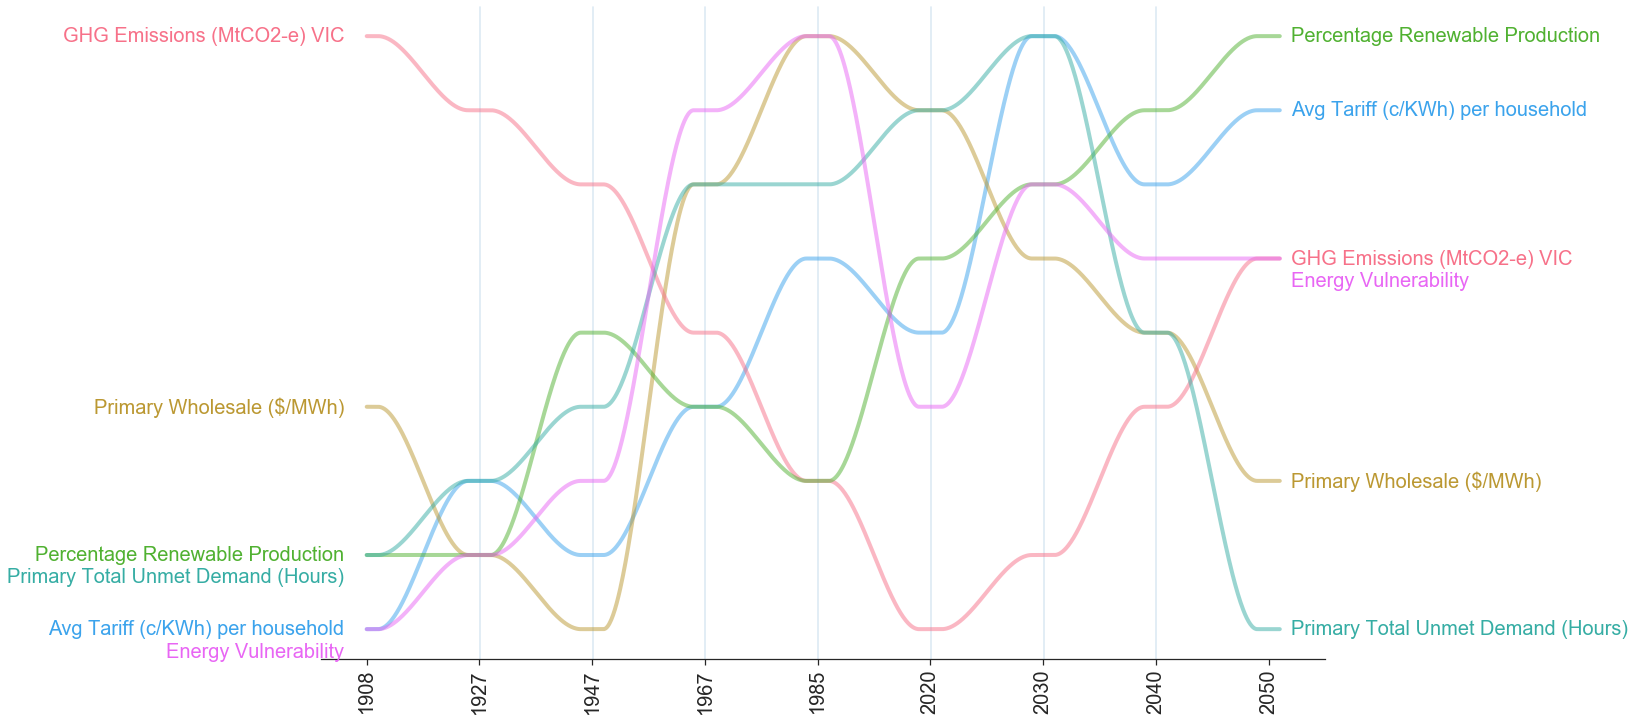

In [288]:
plt.figure(figsize=(18,12))
bumpsplot(data_rank_T, color_dict=input_colors, linewidth_dict=lw, labels=top_inputs)
plt.gca().get_yaxis().set_visible(False)

plt.xticks(np.arange(data_rank_T.shape[1]), ["{}".format(c) for c in data_rank_T.columns], rotation=90, fontsize=20)

for i,d in enumerate(data_rank_T.columns):
    if i != 0 and i != len(data_rank_T.columns)-1:
        plt.axvspan(i-0.005, i+0.005, zorder=0, alpha=0.5)

sns.despine(left=True)

In [289]:
input_colors = defaultdict(lambda: "grey")
lw = defaultdict(lambda: 1)

top_inputs = data_rank.iloc[:, 0].dropna().sort_values().index

for i,c in enumerate(top_inputs):
    input_colors[c] = sns.color_palette("husl", n_colors=len(top_inputs))[i]
    lw[c] = 4


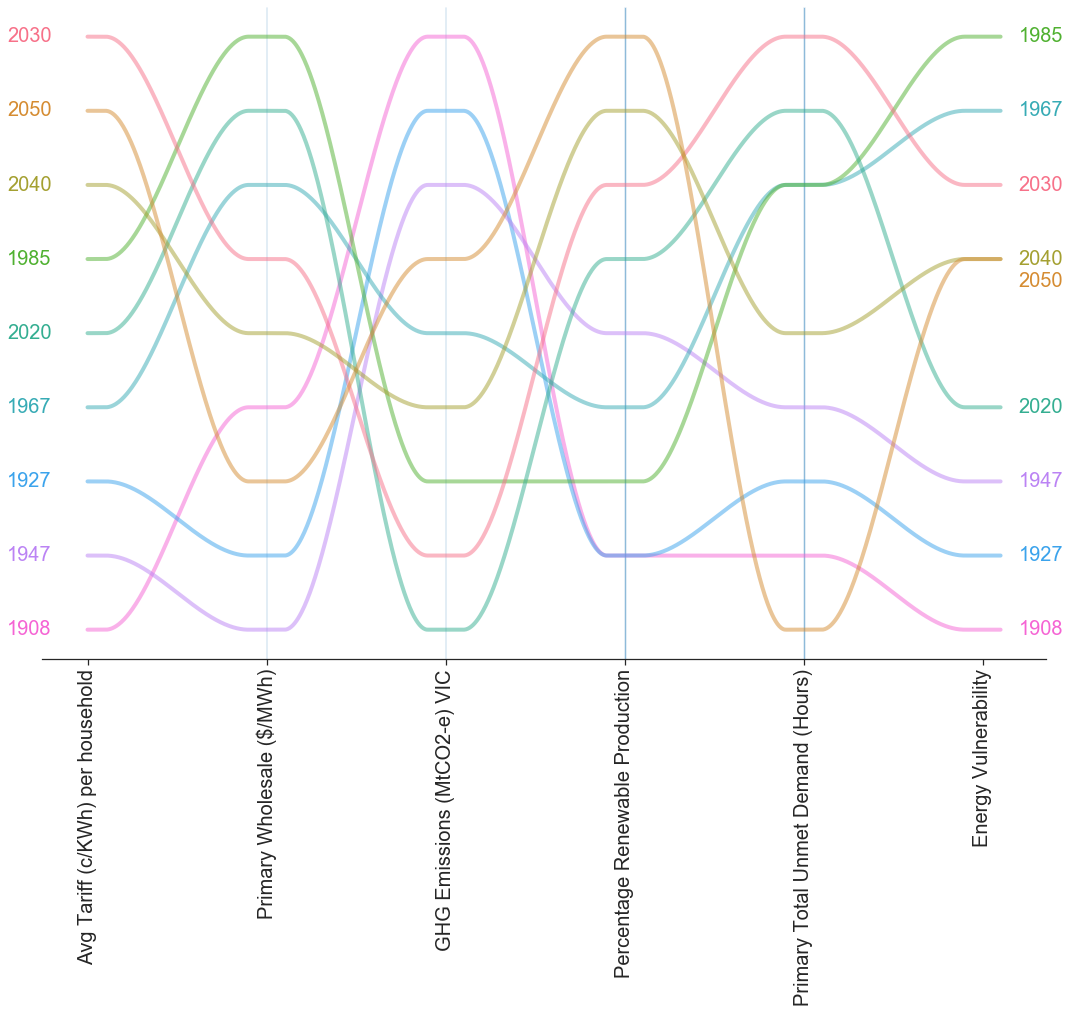

In [290]:
plt.figure(figsize=(18,12))
bumpsplot(data_rank, color_dict=input_colors, linewidth_dict=lw, labels=top_inputs)
plt.gca().get_yaxis().set_visible(False)

plt.xticks(np.arange(data_rank.shape[1]), ["{}".format(c) for c in data_rank.columns], rotation=90, fontsize=20)

for i,d in enumerate(data_rank.columns):
    if i != 0 and i != len(data_rank.columns)-1:
        plt.axvspan(i-0.005, i+0.005, zorder=0, alpha=0.5)

sns.despine(left=True)